In [1]:
!cp -r /content/drive/MyDrive/Pose_Estimation_Paper/* /content/

In [2]:
!unzip -j /content/images.zip -d /content/images/ > /dev/null

In [3]:
!unzip -j /content/images2.zip -d /content/images2/ > /dev/null

In [4]:
import math
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.spatial.transform import Rotation as ROT
from sklearn.model_selection import train_test_split

In [5]:
cam_mat = np.array([[711.111, 0, 256.0], [0, 711.111, 256.0], [0, 0, 1]], dtype=np.float32)
keypts = np.array([
  [6.816, -0.013, 0.021],
  [5.956, -0.013, -3.356],
  [5.777, -1.405, -0.004],
  [5.777, 1.345, -0.004],
  [5.956, -0.013, 1.196],
  [3.661, -12.531, 0.097],
  [-0.306, -12.531, 0.097],
  [1.704, -1.753, 0.097],
  [1.704, 1.889, 0.097],
  [3.661, 12.542, 0.097],
  [-0.306, 12.537, 0.097],
  [-6.720, -0.013, 0.011],
  [-4.292, -0.013, 2.201],
  [-4.292, 1.575, -1.476],
  [-4.292, -1.625, -1.476],
  [-2.516, 0.093, -8.451],
  [0.456, 0.093, -8.451],
  [-1.127, 0.093, -1.775],
  [1.772, 0.025, -1.689],
  [1.919, 0.025, 1.776],
  [-1.596, 0.025, 1.547]
], dtype=np.float32)

In [6]:
df = pd.read_pickle('dataset.zip')

In [7]:
df.head()

,Image,x,y,z,qw,qx,qy,qz,bx,by,...,pk20y,px,py,pz,pqw,pqx,pqy,pqz,dr,dq
0,img1.jpg,0.733,-1.050,60.177,0.424,-0.329,0.838,-0.096,247.680616,240.004065,...,258.898409,0.845582,-1.128232,57.647185,0.432849,-0.312149,0.835873,-0.128532,2.533527,0.075513
1,img2.jpg,-2.675,3.939,55.630,-0.094,-0.304,0.263,0.911,231.409574,316.186593,...,323.063989,-2.419494,3.715695,52.558606,-0.100566,-0.307319,0.270371,0.906830,3.090082,0.022440
2,img3.jpg,-2.389,5.136,56.913,-0.056,-0.477,-0.852,0.209,222.530529,344.785139,...,301.092395,-2.423551,5.274911,58.307099,0.037426,0.476215,0.861147,-0.173909,1.401429,0.081497
3,img4.jpg,-2.446,-1.007,53.320,-0.706,-0.255,0.310,-0.584,222.464975,255.793595,...,217.657242,-2.546036,-0.923423,54.050802,0.682806,0.292231,-0.326075,0.584852,0.742336,0.093440
4,img5.jpg,4.701,0.091,51.103,0.798,-0.505,-0.325,-0.046,354.442635,257.882250,...,271.752007,4.864291,0.234981,52.788851,0.814325,-0.494780,-0.300450,-0.042405,1.699849,0.062826


In [8]:
def quat_diff(quat0, quat1):
    """Return multiplication of two quaternions.

    >>> q = quaternion_multiply([1, -2, 3, 4], [-5, 6, 7, 8])
    >>> numpy.allclose(q, [-44, -14, 48, 28])
    True

    """
    x0, y0, z0, w0 = quat0
    x1, y1, z1, w1 = quat1
    w1 = -1*w1

    out = np.array((
         x1*w0 + y1*z0 - z1*y0 + w1*x0,
        -x1*z0 + y1*w0 + z1*x0 + w1*y0,
         x1*y0 - y1*x0 + z1*w0 + w1*z0,
        -x1*x0 - y1*y0 - z1*z0 + w1*w0), dtype=np.float32)
    
    out = out / np.linalg.norm(out)

    return out

In [9]:
def quat2angle(quat):
  if quat[3] < 0:
    quat = quat*-1
  
  return 2*math.acos(quat[3])

In [10]:
N = len(df)

pred_quats = np.zeros((N,4))
pred_t_vecs = np.zeros((N,3))
del_angle = np.zeros(N)
del_t = np.zeros(N)

for i in tqdm(range(N)):
  res = cv2.solvePnPRansac(keypts, np.reshape(df.iloc[i]['pk0x':'pk20y'].values.astype(np.float32), (21,2)), cam_mat, np.zeros(5))

  pred_quat = ROT.from_matrix(cv2.Rodrigues(res[1])[0]).as_quat()
  pred_t_vec = np.ravel(res[2])

  pred_quats[i] = pred_quat
  pred_t_vecs[i] = pred_t_vec

  quat = np.squeeze(df.iloc[[i]][['qx','qy','qz','qw']].values)
  t_vec = np.squeeze(df.iloc[[i]][['x','y','z']].values)

  del_angle[i] = abs(quat2angle(quat_diff(quat, pred_quat)))
  del_t[i] = np.linalg.norm(t_vec - pred_t_vec)

df['px'] = pred_t_vecs[:,0]
df['py'] = pred_t_vecs[:,1]
df['pz'] = pred_t_vecs[:,2]

df['pqw'] = pred_quats[:,3]
df['pqx'] = pred_quats[:,0]
df['pqy'] = pred_quats[:,1]
df['pqz'] = pred_quats[:,2]

df['dr'] = del_t
df['dq'] = del_angle

100%|██████████| 1000/1000 [00:02<00:00, 406.75it/s]


(array([918.,  37.,   4.,  17.,  14.,   5.,   2.,   2.,   0.,   1.]),
 array([6.20910809e-02, 3.23321481e+01, 6.46022050e+01, 9.68722620e+01,
        1.29142319e+02, 1.61412376e+02, 1.93682433e+02, 2.25952490e+02,
        2.58222547e+02, 2.90492604e+02, 3.22762661e+02]),
 <a list of 10 Patch objects>)

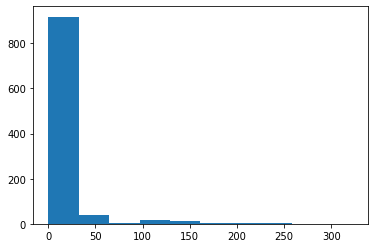

In [11]:
plt.hist(df['dr'])

(array([836.,  58.,  29.,  12.,   4.,   3.,   8.,   6.,  15.,  29.]),
 array([  0.23738813,  18.14258413,  36.04778013,  53.95297612,
         71.85817212,  89.76336811, 107.66856411, 125.5737601 ,
        143.4789561 , 161.3841521 , 179.28934809]),
 <a list of 10 Patch objects>)

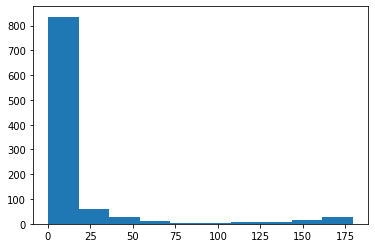

In [12]:
plt.hist(df['dq']*180/math.pi)

In [13]:
df.to_pickle('dataset.zip')

In [14]:
!cp -r /content/dataset.zip /content/drive/MyDrive/Pose_Estimation_Paper/

In [15]:
X_train, X_test, _, _ = train_test_split(np.arange(N), np.arange(N), test_size=0.2, random_state=42)

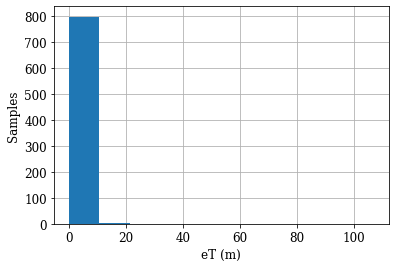

In [28]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
plt.grid(zorder=0)
plt.hist(df.iloc[X_train]['dr'], zorder=3)
plt.xlabel('eT (m)')
plt.ylabel('Samples')
plt.savefig('pnp-train-dr-hist.eps', bbox_inches='tight')

In [17]:
df.iloc[X_train]['dr'].mean()

1.9411954222281929

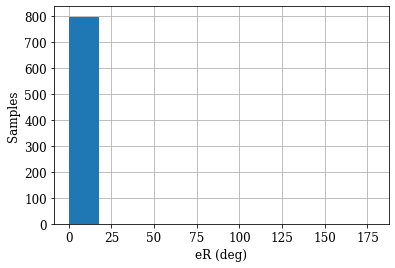

In [33]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
plt.grid(zorder=0)
plt.hist(df.iloc[X_train]['dq']*180/math.pi, zorder=3)
plt.xlabel('eR (deg)')
plt.ylabel('Samples')
plt.savefig('pnp-train-dq-hist.eps', bbox_inches='tight')

In [19]:
(df.iloc[X_train]['dq']*180/math.pi).mean()

4.015412378589921

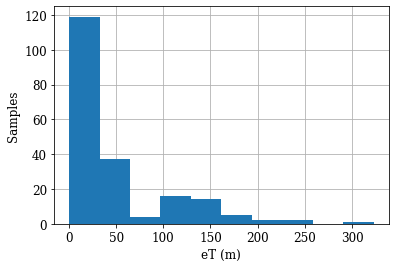

In [30]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
plt.grid(zorder=0)
plt.hist(df.iloc[X_test]['dr'], zorder=3)
plt.xlabel('eT (m)')
plt.ylabel('Samples')
plt.savefig('pnp-test-dr-hist.eps', bbox_inches='tight')

In [21]:
df.iloc[X_test]['dr'].mean()

47.01348104438587

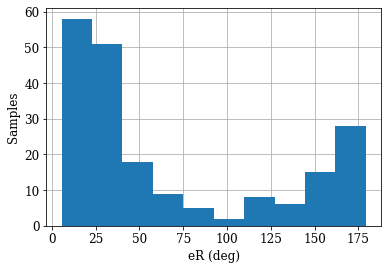

In [32]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
plt.grid(zorder=0)
plt.hist(df.iloc[X_test]['dq']*180/math.pi, zorder=3)
plt.xlabel('eR (deg)')
plt.ylabel('Samples')
plt.savefig('pnp-test-dq-hist.eps', bbox_inches='tight')

In [23]:
(df.iloc[X_test]['dq']*180/math.pi).mean()

67.3523507314124